### Local overlap computation

Given a $t$-digest $\{ C_1, \ldots, C_n \}$, we compute the function mapping a centroid $C_i$ to the Kolmogorov-Smirnov statistic of the sets underlying $C_i$ and $C_{i+1}$, i.e., a measure of the overlap between neighborhood centroids. The K-S statistic ranges from $0$ (limit of the completely mixed case) to $1$ (completely separated case), and we may view a centroid as occupying an interval quantile space, hence the mapping may be viewed as a function from the unit interval to itself.

In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

In [2]:
RESULTS_LOCATION  = '../../../../data/results/'
IMG_LOCATION = '../images/'

In [3]:
class CentroidOverlapComputation(object):
    
    def __init__(self, f, label=None):
        self.filename = f
        self.label = label
        
    def readable_name(self):
        return self.filename.rstrip('.csv').split('=')[-1]
    
    def _get_counts(self):
        with open(RESULTS_LOCATION + self.filename, 'r') as f:
            self.centroids = [[float(y) for y in line.rstrip('\n').split(',') if len(y) > 0] for line in f.readlines()]
        
    def _verify_total_count(self):
        self.counts = [len(x) - 1 for x in self.centroids]
        self.total_count = sum(self.counts)
        #print(self.total_count)
        #assert('samples={}'.format(self.total_count) in self.filename)

    def _compute_ks_stats(self):
        self.ks = []
        for idx in range(len(self.centroids) - 1):
            centroid = self.centroids[idx][1:]
            next_centroid = self.centroids[idx + 1][1:]
            self.ks.append(ks_2samp(centroid, next_centroid)[0])

    def _compute_cum_norm_weight(self):
        q = [count / self.total_count for count in self.counts]
        self.cum_weight = [sum(q[:i + 1]) for i in range(len(q))]
        
    def plot(self, line):
        assert(len(self.ks) == len(self.cum_weight) - 1)
        plt.plot(self.cum_weight[:-1], self.ks, line, label=self.label)
        
    def prepare(self):
        self._get_counts()
        self._verify_total_count()
        self._compute_ks_stats()
        self._compute_cum_norm_weight()

In [4]:
def display_ks_curves(res_files, title=None, imgname=None, plot_lines=['-']):
    cents = [CentroidOverlapComputation(*f) for f in res_files]
    for c in cents:
        c.prepare()
        c.plot(plot_lines[cents.index(c)])
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.xlabel('cumulative centroid weight')
    plt.ylabel('local KS statistic')
    if imgname is not None:
        plt.savefig(IMG_LOCATION + 'plot_' + imgname + '.png', dpi=300)
    plt.show()

#### Careful attack

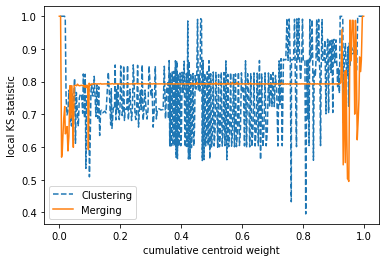

In [5]:
careful_tree = 'centroids_careful_iterations=1063_samples=204157_scalefunc=K_0_delta=500_centroids=349_sizeBytes=4220_impl=tree.csv'
careful_merging = 'centroids_careful_iterations=917_samples=1136304_scalefunc=K_0_delta=500_centroids=350_sizeBytes=5632_impl=merging_alt_true.csv'

display_ks_curves([(careful_tree, 'Clustering'), (careful_merging, 'Merging')], plot_lines=['--', '-'])

##### Careful attack data, sorted

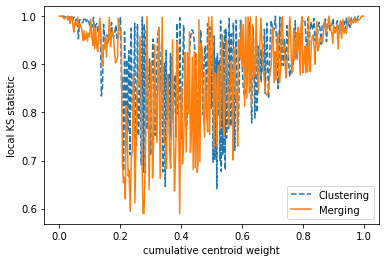

In [6]:
careful_tree_sorted = 'centroids_careful_iterations=1063_samples=204157_scalefunc=K_0_delta=500_centroids=315_sizeBytes=3812_impl=tree_sorted.csv'
careful_merging_sorted = 'centroids_careful_iterations=917_samples=1136304_scalefunc=K_0_delta=500_centroids=305_sizeBytes=4912_impl=merging_alt_true_sorted.csv'

display_ks_curves([(careful_tree_sorted, 'Clustering'), (careful_merging_sorted, 'Merging')], plot_lines=['--', '-'])

#### IID case

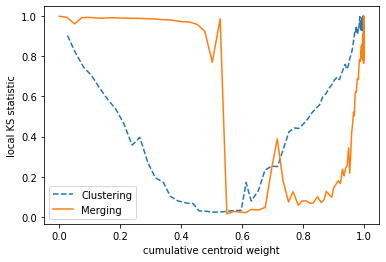

In [7]:
_fname = lambda x : 'iid_loguniform2_lgN=20_lgT=2_{}_compr=500_K_2_GLUED_centroids.csv'.format(x)
display_ks_curves([(_fname(impl.lower()), impl) for impl in ['Clustering', 'Merging']], plot_lines=['--', '-'])